# Introuction to Time Series Analysis
- Trend
- Seasonality

In [43]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import math
matplotlib.style.use('fivethirtyeight')

In [44]:
#matplotlib.style.available

In [45]:
start_time  = dt.date(2000, 1, 1)
end_time  = dt.date(2022, 12, 31)

dates = pd.date_range(start_time, end_time, freq='M')
np.random.seed(seed=1111)
values = np.random.randint(low = -50 , high = +50, size=len(dates))
sales = [ math.exp(idx*6/len(values)) + val  for idx , val in enumerate(values)]

df = pd.DataFrame(data=sales, index=dates, columns=['Sales'], dtype='float64')
df['lags_1'] = df['Sales'].shift(1)
#df.dropna(inplace=True)
df


,Sales,lags_1
2000-01-31,-21.000000,NaN
2000-02-29,6.021977,-21.000000
2000-03-31,32.044437,6.021977
2000-04-30,-36.932609,32.044437
2000-05-31,-14.909151,-36.932609
...,...,...
2022-08-31,342.876990,379.094992
2022-09-30,328.830014,342.876990
2022-10-31,338.957822,328.830014
2022-11-30,426.264257,338.957822


<Axes: >

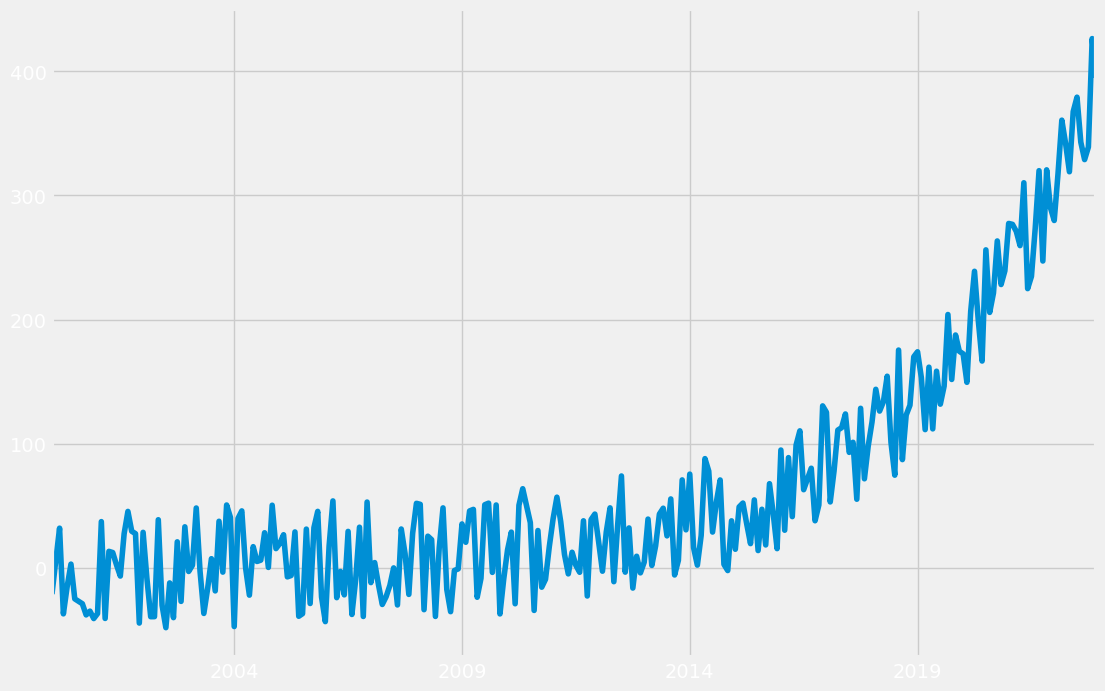

In [46]:
df['Sales'].plot(figsize=(12,8))

## Trend
- prediction using Linear Regression
  - Find trend using Statsmodel, deterministics trend

In [47]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
modified_df = df.dropna()
X = modified_df[['lags_1']]
y = modified_df['Sales']
lr.fit(X, y)
ypred = pd.Series(lr.predict(X), index=X.index)
modified_df['ypred'] = ypred
modified_df.head(3)


C:\Users\DELL\AppData\Local\Temp\ipykernel_13936\2319046961.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_df['ypred'] = ypred


,Sales,lags_1,ypred
2000-02-29,6.021977,-21.000000,-13.434552
2000-03-31,32.044437,6.021977,11.637206
2000-04-30,-36.932609,32.044437,35.781584


### Trend 


In [48]:
df.head(3)

,Sales,lags_1
2000-01-31,-21.000000,NaN
2000-02-29,6.021977,-21.000000
2000-03-31,32.044437,6.021977


## creating the moving avg
- moving average is a technique to get rid of the noise in the data


<Axes: >

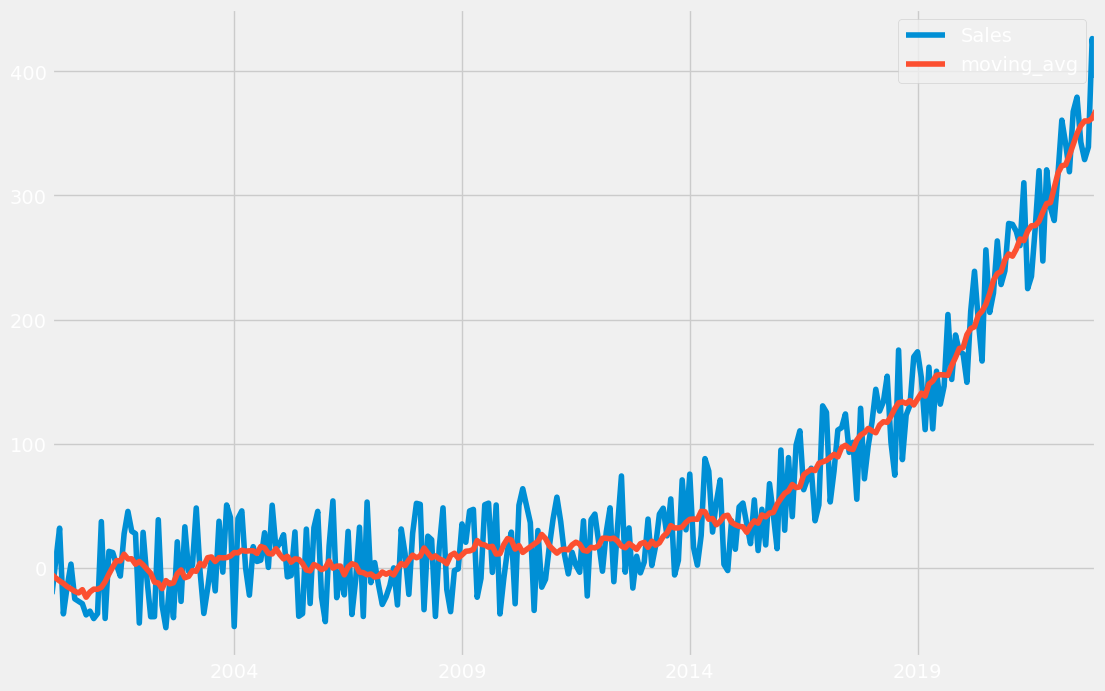

In [49]:
Moving_avg = df['Sales'].rolling(
    window=12,  # 12 months
    center=True,  # center the window
    min_periods=6,  # min number of periods in window
).mean()

df['moving_avg'] = Moving_avg
df[['Sales', 'moving_avg']].plot(figsize=(12,8))


In [50]:
## Creating a trend feature using Statsmodels
from statsmodels.tsa.deterministic import DeterministicProcess

New_data  = df['Sales']
dp = DeterministicProcess(
    index= New_data.index, # the index must be a DatetimeIndex
    constant=True,  # include a constant
    order=3, # include up to a third order polynomial trend
    drop=True, # drop terms with high correlation
)

dp_col  = dp.in_sample() 
dp_col

,const,trend,trend_squared,trend_cubed
2000-01-31,1.0,1.0,1.0,1.0
2000-02-29,1.0,2.0,4.0,8.0
2000-03-31,1.0,3.0,9.0,27.0
2000-04-30,1.0,4.0,16.0,64.0
2000-05-31,1.0,5.0,25.0,125.0
...,...,...,...,...
2022-08-31,1.0,272.0,73984.0,20123648.0
2022-09-30,1.0,273.0,74529.0,20346417.0
2022-10-31,1.0,274.0,75076.0,20570824.0
2022-11-30,1.0,275.0,75625.0,20796875.0


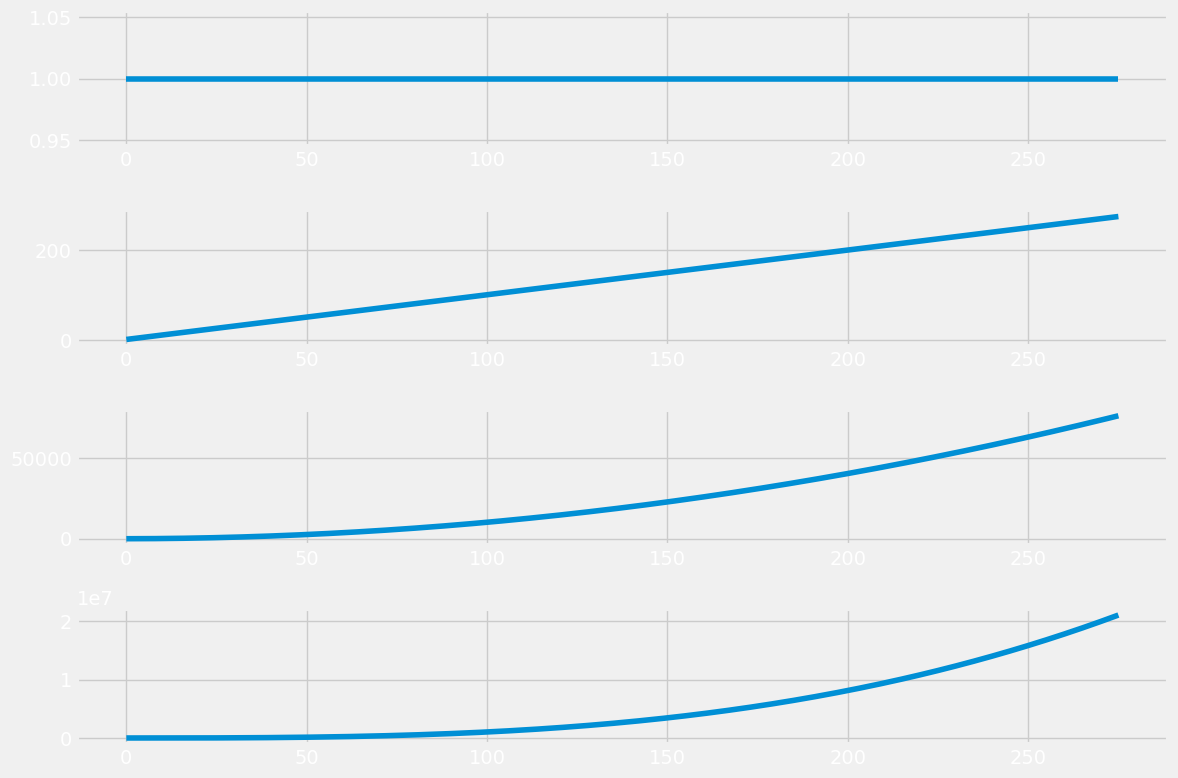

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 1, figsize=(12, 8))
ax[0].plot(dp_col['const'].values)
ax[1].plot(dp_col[dp_col.columns[1]].values)
ax[2].plot(dp_col[dp_col.columns[2]].values)
ax[3].plot(dp_col[dp_col.columns[3]].values)
fig.tight_layout()

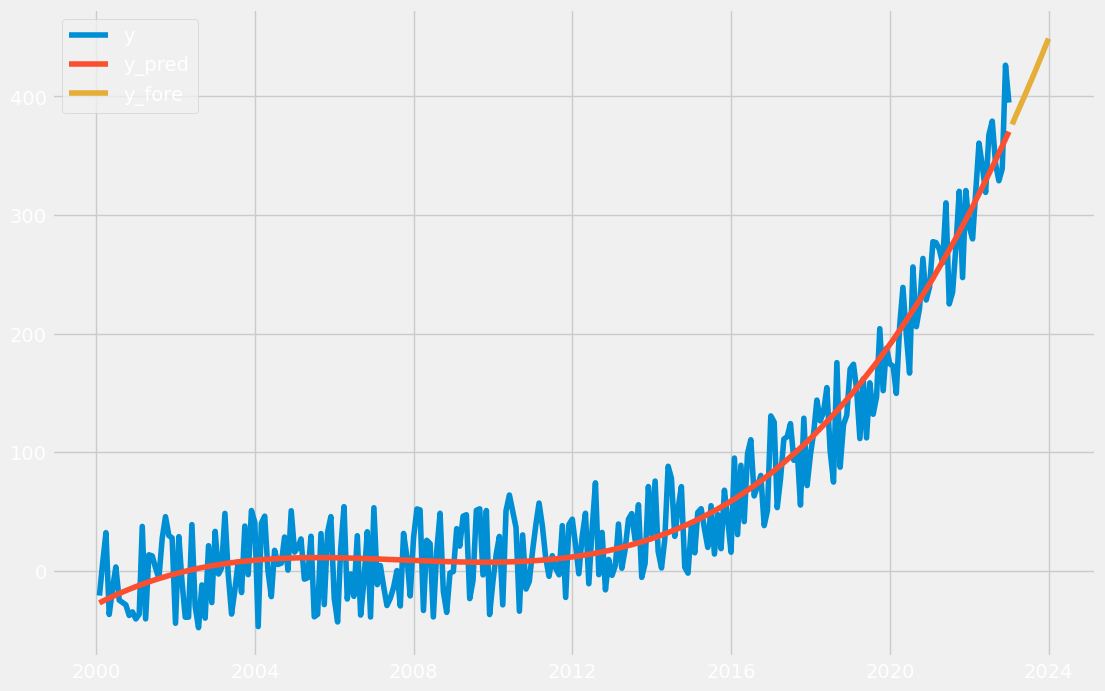

In [52]:
X_fore = dp.out_of_sample(
    steps=12 # number of steps to forecast
    )
X = dp_col
y = New_data
lr = LinearRegression()
lr = lr.fit(X, y)
y_pred = pd.Series(lr.predict(X), index=X.index)
y_fore =pd.Series(lr.predict(X_fore), index=X_fore.index)


fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(y, label='y')
ax.plot(y_pred, label='y_pred')
ax.plot(y_fore, label='y_fore')
ax.legend() 

## Seasonality
- Fourier Features
- deseasonalize the data
- cycle of the data

In [53]:
import numpy as np 

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float64)
    k = 2 * np.pi * freq * time / len(index)
    features = {}
    
    for i  in range(1, order):
        features[f'sin_{i}'] = np.sin(i * k)
        features[f'cos_{i}'] = np.cos(i * k)
        
    return pd.DataFrame(features, index=index)


fr_features_df  = fourier_features(index=df.index, freq=12, order=4)
fr_features_df

,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3
2000-01-31,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2000-02-29,0.269797,0.962917,0.519584,0.854419,0.730836,0.682553
2000-03-31,0.519584,0.854419,0.887885,0.460065,0.997669,-0.068242
2000-04-30,0.730836,0.682553,0.997669,-0.068242,0.631088,-0.775711
2000-05-31,0.887885,0.460065,0.816970,-0.576680,-0.136167,-0.990686
...,...,...,...,...,...,...
2022-08-31,-0.979084,0.203456,-0.398401,-0.917211,0.816970,-0.576680
2022-09-30,-0.887885,0.460065,-0.816970,-0.576680,0.136167,-0.990686
2022-10-31,-0.730836,0.682553,-0.997669,-0.068242,-0.631088,-0.775711
2022-11-30,-0.519584,0.854419,-0.887885,0.460065,-0.997669,-0.068242


<Axes: >

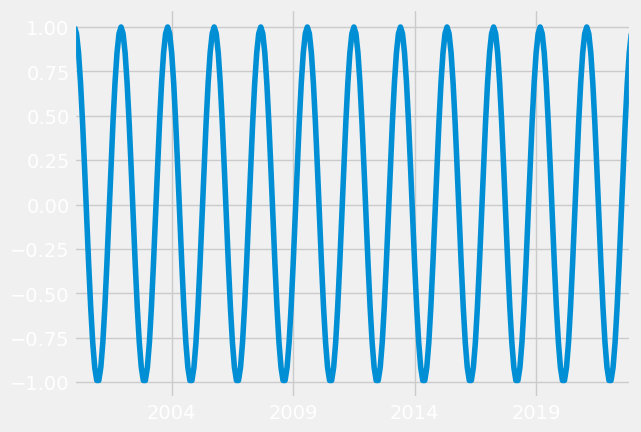

In [54]:
fr_features_df['cos_1'].plot()

<Axes: >

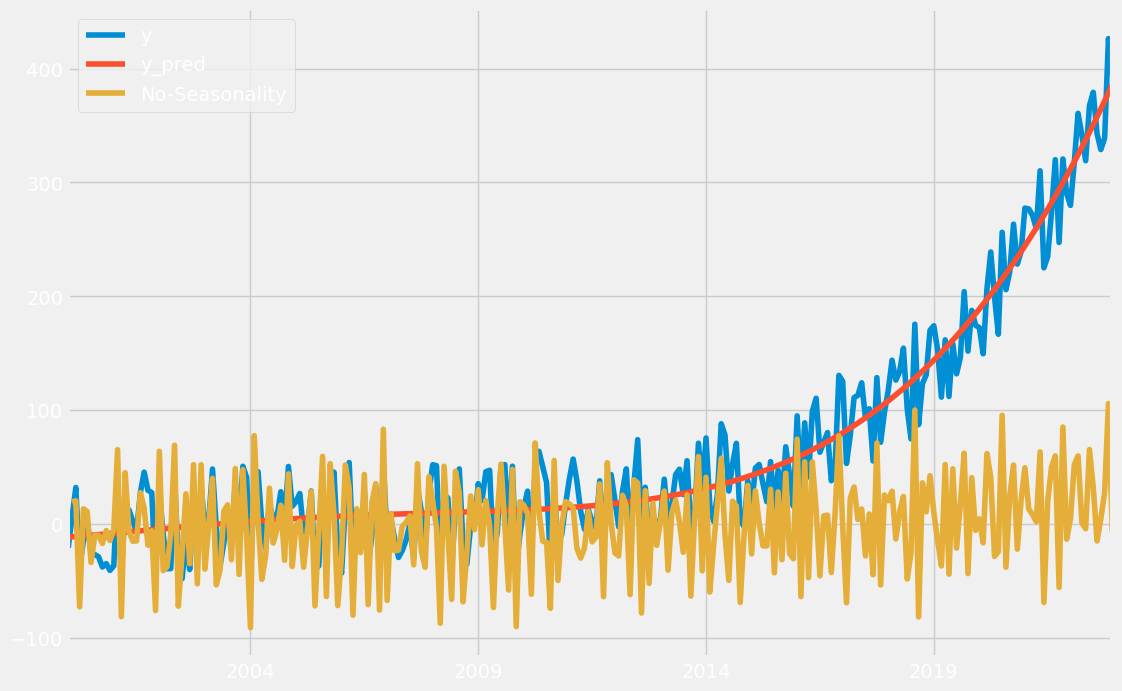

In [55]:
from statsmodels.tsa.deterministic import DeterministicProcess , CalendarFourier

fourier = CalendarFourier(freq='M', order=10)
y  = df['Sales']


season_dp = DeterministicProcess(
    index= y.index,
    constant=True,
    order=10,
    seasonal=True, # include a weekly seasonal component
    additional_terms=[fourier], # include Monthly Fourier terms
    drop=True,  
)

X = season_dp.in_sample()

model = LinearRegression().fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

pd.DataFrame(data={'y': y, 'y_pred': y_pred, 'No-Seasonality' : y-ypred}).plot(figsize=(12, 8))


In [56]:
holidays = pd.read_csv('Data/holidays_events.csv')
holidays = holidays[['date', 'description']]
holidays.set_index('date', inplace=True)
holidays


#* one hot encoding
#* with pandas get_dummies

holidays_one_hot = pd.get_dummies(holidays, prefix='', prefix_sep='')
holidays_one_hot.head(3)


#* with sklearn OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(sparse=False)
holidays_ohe = pd.DataFrame(
    OHE.fit_transform(holidays),
    index=holidays.index,
    columns=holidays['description'].unique(),
)
holidays_ohe.shape , holidays_one_hot.shape

c:\Users\DELL\anaconda3\envs\tfgpy\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((350, 103), (350, 103))

## Hybrid model 
- Trend + Seasonality + Residuals
- Residuals: the noise in the data

### Steps
- Extract the Time features from the data {trend, seasnality, cycle, fourier features}
- Fit a model to the data -> to predict the trend, seasonality, cycle etc
- Create a residual by subtracting the predicted value from the actual value
- train another model on the residuals with the same features
- add the two predictions together to get the final prediction


In [57]:
from statsmodels.tsa.deterministic import DeterministicProcess , CalendarFourier

fourier = CalendarFourier(freq='Y', order=10)

#* step 1: create a df with extrated time features using DeterministicProcess

y = df['Sales']
season_dp = DeterministicProcess(
    index= y.index,
    constant=True,
    order=3,
    period=12, #* 12 months
    additional_terms=[fourier], #* include Monthly Fourier terms
    seasonal=True, #* include a weekly seasonal component
    drop=True,
)

X_1 = season_dp.in_sample()

#* step 2: fit on lr model
lr_model = LinearRegression().fit(X_1, y)

#* step 3: predict on X_1
y_pred = pd.Series(lr_model.predict(X_1), index=y.index)

#* step 4: create a deseasonalized feature by substracting the predicted values from the original values
y_deseason = y - y_pred


#* hybrid model
#* train on deseasonalized feature with XGBoost

import xgboost as xgb
xgb_model  = xgb.XGBRegressor()
xgb_model.fit(X_1, y_deseason)

pred = pd.Series(xgb_model.predict(X_1), index = y_deseason.index)

X_fore = season_dp.out_of_sample(steps=12)
Y_lr = lr_model.predict(X_fore)
Y_xgb = xgb_model.predict(X_fore)
y_fore = Y_lr + Y_xgb
y_fore = pd.Series(y_fore, index=X_fore.index)



In [58]:
lr_model.score(X_1, y) , xgb_model.score(X_1, y - lr_model.predict(X_1))


(0.9125461143369689, 0.9998404722754057)

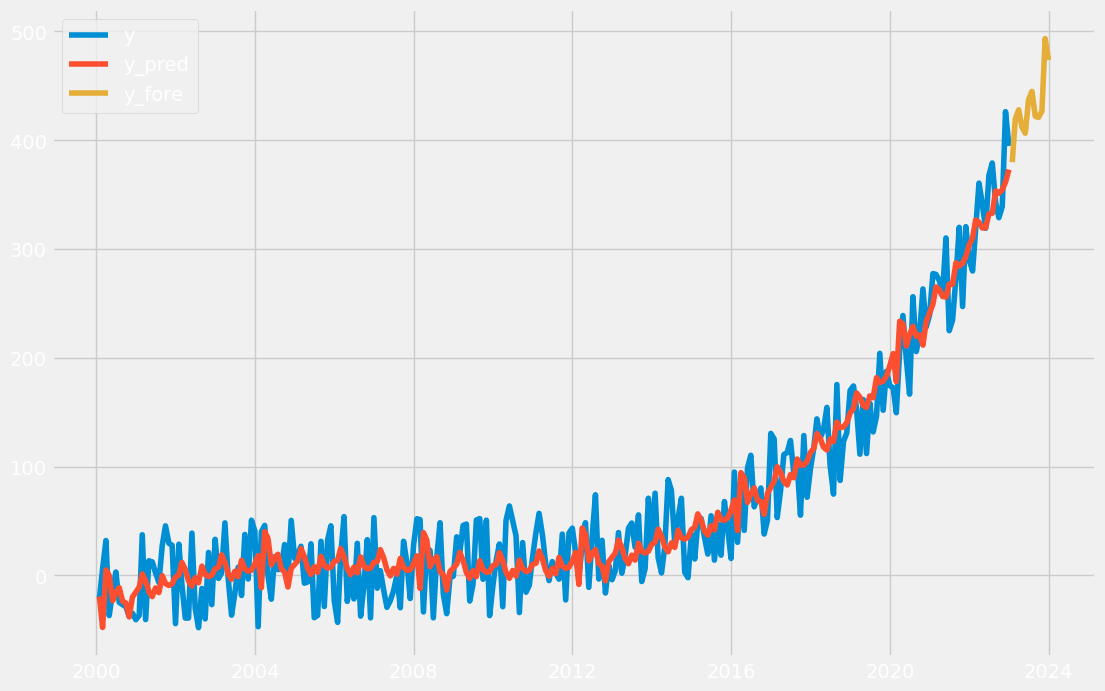

In [59]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(y, label='y')
ax.plot(y_pred, label='y_pred')
ax.plot(y_fore, label='y_fore')
ax.legend()

In [60]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor


def CreateTimeFeatures(df, period=12, Trend_order=3, fourier_order=10, calender_freq="Y", IncludeFouriere=True):
    from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
    if IncludeFouriere:
        fourier_feats = CalendarFourier(freq=calender_freq, order=fourier_order)
        addition_terms = [fourier_feats]
    else :
        addition_terms = None
    time_feats = DeterministicProcess(
        index=df.index,
        constant=True,
        order=Trend_order,
        period=period,#* 12 months
        seasonal=True, #* include a weekly seasonal component
        additional_terms=addition_terms, #* include Monthly Fourier terms
        drop=True,
    )
    return time_feats


class HybridModel():
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
    
    def fit(self, X, y):
        self.model_1.fit(X, y)
        y_deseasoned = y - pd.Series(self.model_1.predict(X), index=y.index)
        self.model_2.fit(X, y_deseasoned)
        
    def predict(self, X):
        y1 = self.model_1.predict(X)
        y2 = self.model_2.predict(X)
        return y1 + y2


y = df['Sales']
features = CreateTimeFeatures(y, period=12, Trend_order=3, fourier_order=3, calender_freq="Y", IncludeFouriere=True)

X = features.in_sample()
X_fore = features.out_of_sample(steps=12)

hybrid_model = HybridModel(LinearRegression(), XGBRegressor())
hybrid_model.fit(X, y)

y_lr_pred = pd.Series(hybrid_model.model_1.predict(X), index=y.index)
y_xgb_pred = pd.Series(hybrid_model.model_2.predict(X), index=y.index)

y_pred_total = pd.Series(hybrid_model.predict(X), index=y.index)
y_fore = pd.Series(hybrid_model.predict(X_fore), index=X_fore.index)


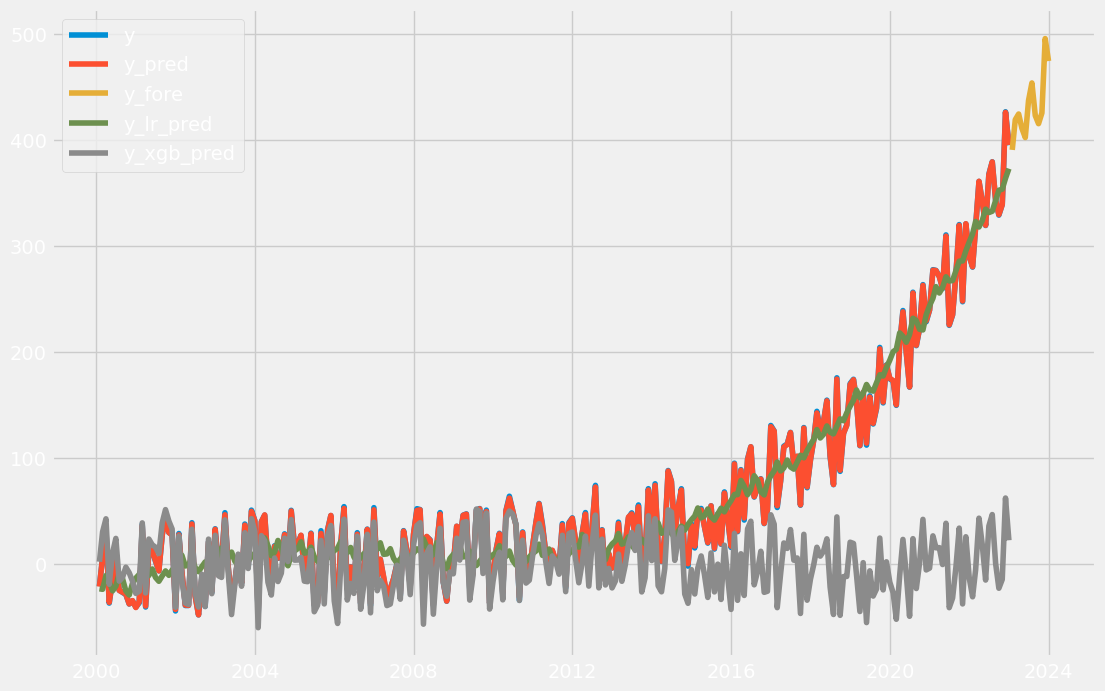

In [61]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(y, label='y')

ax.plot(y_pred_total, label='y_pred')
ax.plot(y_fore, label='y_fore')
ax.plot(y_lr_pred, label='y_lr_pred')
ax.plot(y_xgb_pred, label='y_xgb_pred')
ax.legend()

## Multiplicative Model


In [62]:
def make_multistep_target(ts, steps, reverse=False):
    shifts = reversed(range(steps)) if reverse else range(steps)
    return pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in shifts}, axis=1)

def make_lags(ts, lags, reverse=False):
    shifts = reversed(range(lags)) if reverse else range(lags)
    return pd.concat({f'lags_{i + 1}': ts.shift(i) for i in shifts}, axis=1)

# make_multistep_target(df['Sales'], 3, reverse=True).head(5)


# shifts = reversed(range(3))
# pd.concat({f"y_step_{i+1}" :df['Sales'].shift(-i) for i in shifts}, axis=1)


In [63]:
store_sales = pd.read_csv(
    'Data/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    parse_dates=['date'],
    dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'uint32'},
    infer_datetime_format=True,
    )
#store_sales.set_index('date', inplace=True)
store_sales['date'] = store_sales['date'].dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()


In [64]:
store_sales.head(3)

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0

In [65]:
family_sales = (
    store_sales.groupby(['family','date'])
    .mean()
    .unstack('family')
    .loc["2017"]
)

family_sales

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   
...               ...       ...        ...          ...       ...   
2017-08-11   8.166667  0.129630   6.500000  3502.055664  0.000000   
2017-08-12   7.462963  0.055556   6.833333  3376.259277  0.000000   
2017-08-13   8.907408  0.166667   8.018518  3747.296387  0.018519   
2017-08-14   5.407407  0.166667   6.240741  3237.629639  0.000000   
2017-08-15   6.240741  0.148148   6.277778  3162.462891  0.000000   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124146   10.629630  1711.907349  1204.203735  404.300049   
2017-01-04   594.160645   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   
...                 ...         ...          ...          ...         ...   
2017-08-11   522.305298   16.111111  1031.148193   831.648132  345.934967   
2017-08-12   507.473114   15.722222  1072.870361   793.592590  290.553558   
2017-08-13   615.976990   10.074074  1143.648193   928.000000  325.801361   
2017-08-14   518.564026   11.000000  1019.111084   797.222229  271.532257   
2017-08-15   539.966553   11.055555  1082.851807   753.833313  276.582458   

            ... onpromotion                                        \
family      ...   MAGAZINES      MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                     
2017-01-01  ...         0.0   0.018519      0.111111     0.018519   
2017-01-02  ...         0.0   0.462963     10.592593     0.537037   
2017-01-03  ...         0.0   0.481481      9.722222     0.444444   
2017-01-04  ...         0.0   0.370370     12.037037     0.444444   
2017-01-05  ...         0.0   8.981481      5.666667     0.000000   
...         ...         ...        ...           ...          ...   
2017-08-11  ...         0.0  22.925926      9.000000     0.000000   
2017-08-12  ...         0.0   0.000000      8.703704     0.000000   
2017-08-13  ...         0.0   0.000000      9.240741     0.000000   
2017-08-14  ...         0.0   0.000000      8.722222     0.000000   
2017-08-15  ...         0.0   0.000000      8.814815     0.000000   

                                                                          \
family     PLAYERS AND ELECTRONICS    POULTRY PREPARED FOODS     PRODUCE   
date                                                                       
2017-01-01                0.000000   0.000000       0.037037    0.129630   
2017-01-02                0.000000   0.259259       1.166667    5.629630   
2017-01-03                0.000000   0.388889       1.351852   56.296296   
2017-01-04                0.000000   0.296296       5.444444  101.277778   
2017-01-05                0.000000   0.296296       0.907407    5.018519   
...                            ...        ...            ...         ...   
2017-08-11                0.000000  27.407407       0.537037    6.000000   
2017-08-12                0.018519   0.111111       0.277778    6.000000   
2017-08-13                0.000000   0.185185       0.222222    5.907407   
2017-08-14                0.000000   0.129630       0.148148    6.018519   
2017-08-15     

In [66]:
test = pd.read_csv(
    'Data/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'], #* to speed up parsing
    infer_datetime_format=True, #* to speed up parsing
    )
test['date'] = test['date'].dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()


# test_sales = (
#     test.groupby(['family', 'date'])
#     .mean()
#     .unstack('family')
# )
# test_sales
test

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...                                  ...          ...
9         SEAFOOD    2017-08-27  3022271            0
                     2017-08-28  3024053            0
                     2017-08-29  3025835            0
                     2017-08-30  3027617            0
                     2017-08-31  3029399            0

[28512 rows x 2 columns]

In [67]:
y = family_sales.loc[:, "sales"]  # * all rows and sales column only
y = make_multistep_target(y, 16, reverse=False).dropna()

X = make_lags(family_sales["sales"], 4, reverse=False).dropna()  # * all rows and 4 lags columns only

y , X = y.align(X, axis=0, join='inner') #* aligning the index of y and X

y.shape , X.shape


((209, 528), (209, 132))

In [68]:
X

lags_1                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   
2017-01-06   6.018518  0.277778   6.518518  3507.277832  0.537037   
2017-01-07  10.259259  0.259259  10.037037  4848.518555  0.481481   
2017-01-08   9.388889  0.240741  11.611111  5503.647949  0.722222   
...               ...       ...        ...          ...       ...   
2017-07-27   6.277778  0.240741   3.981482  2623.814697  0.037037   
2017-07-28   6.370370  0.166667   4.092593  3554.111084  0.000000   
2017-07-29  10.018518  0.203704   7.185185  4612.685059  0.000000   
2017-07-30   9.796296  0.259259   8.388889  5074.629395  0.018519   
2017-07-31   6.685185  0.314815   5.111111  3620.444336  0.018519   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-04   594.160645   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   
2017-01-06   513.873291   18.333334  1257.611084   864.333313  317.622406   
2017-01-07   649.424133   21.444445  1761.351807  1173.463013  381.874756   
2017-01-08   776.717834   10.925926  1784.018555  1323.314819  429.561798   
...                 ...         ...          ...          ...         ...   
2017-07-27   411.163452   19.222221  1395.314819   623.944458  213.962723   
2017-07-28   493.264771   16.666666  1548.685181   764.481506  335.682251   
2017-07-29   596.895386   19.500000  1906.611084   983.037048  354.486481   
2017-07-30   701.206299   10.833333  2107.722168  1100.592651  395.133331   
2017-07-31   562.624695    8.629630  1655.277832   860.981506  308.857666   

            ...    lags_4                                         \
family      ... MAGAZINES       MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-04  ...  0.074074    5.013166      2.629630     0.074074   
2017-01-05  ...  7.777778  488.522308    714.370361    12.814815   
2017-01-06  ...  3.500000  427.520905    488.333344     8.870370   
2017-01-07  ...  3.500000  369.121490    426.574066     8.129630   
2017-01-08  ...  3.203704  368.945679    360.925934     7.629630   
...         ...       ...         ...           ...          ...   
2017-07-27  ...  6.370370  349.225952    315.592590     8.407408   
2017-07-28  ...  5.425926  308.749786    257.685181     6.518518   
2017-07-29  ...  5.111111  307.781006    267.981476     6.722222   
2017-07-30  ...  5.388889  342.936493    217.944443     6.481482   
2017-07-31  ...  5.925926  514.790161    258.129639     7.222222   

                                                                            \
family     PLAYERS AND ELECTRONICS     POULTRY PREPARED FOODS      PRODUCE   
date                                                                         
2017-01-04                0.222222    2.855537       1.040722    31.163778   
2017-01-05               22.777779  581.413147     153.555542  3409.500488   
2017-01-06               13.555555  462.013672     125.820541  3394.559570   
2017-01-07               12.092592  431.276398     116.740814  3467.447998   
2017-01-08               10.333333  345.673492     101.434570  2069.316650   
...                            ...         ...            ...          ...   
2017-07-27                9.574074  360.456665      89.320770  2168.834961   
2017-07-28                8.481482  310.549103      76.463348  2138.104736   
2017-07-29                9.296296  306.457184      82.526276  2702.183838   
2017-07-30                9.833333  269.486877      77.199745  1675.579468   
20

## Label endocer to extend the data



In [69]:
#import labbel encode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X = (X
     .stack('family') #* reverse of unstack
     .reset_index('family') #* reverse of set_index
     .assign(family = lambda x : le.fit_transform(x['family'])) #* label encoding
     )

y = y.stack('family')
y


y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-04 AUTOMOTIVE                     6.833333     6.333333     6.018518   
           BABY CARE                      0.333333     0.351852     0.277778   
           BEAUTY                         6.888889     5.925926     6.518518   
           BEVERAGES                   3911.833252  3258.796387  3507.277832   
           BOOKS                          0.759259     0.407407     0.537037   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955658   403.601349   377.313995   
           PREPARED FOODS                84.698647    87.836800    88.735970   
           PRODUCE                     2257.140625  2609.180176  3122.895752   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333332    57.481480   
           SEAFOOD                       20.488333    20.346851    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-04 AUTOMOTIVE                    10.259259     9.388889     5.944445   
           BABY CARE                      0.259259     0.240741     0.444444   
           BEAUTY                        10.037037    11.611111     5.648148   
           BEVERAGES                   4848.518555  5503.647949  3448.203613   
           BOOKS                          0.481481     0.722222     0.500000   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436096   533.497009   416.454041   
           PREPARED FOODS                77.172997    91.886765   100.384964   
           PRODUCE                     1792.220947  2079.319336  2418.970215   
           SCHOOL AND OFFICE SUPPLIES    51.907406    63.222221    85.203705   
           SEAFOOD                       17.116297    25.553965    24.209518   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-04 AUTOMOTIVE                     4.777778     6.314815     5.388889   
           BABY CARE                      0.240741     0.277778     0.296296   
           BEAUTY                         6.500000     5.277778     4.370370   
           BEVERAGES                   3171.740723  3046.870361  2693.722168   
           BOOKS                          0.518519     0.481481     0.388889   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051758   313.780884   
           PREPARED FOODS               102.248146    86.627441    77.344131   
           PRODUCE                     2675.105957  2111.133301  2168.535400   
           SCHOOL AND OFFICE SUPPLIES   100.277779    64.407410    59.759258   
           SEAFOOD                       23.512852    18.419851    18.481131   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-04 AUTOMOTIVE                     5.240741     8.500000    10.259259   
           BABY CARE                      0.296296     0.388889     0.425926   
           BEAUTY                         4.703704     7.777778     9.037037   
           BEVERAGES                   3226.037109  4667.296387  5580.611328   
           BOOKS                          0.444444     0.574074     0.555556   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270233   278.819885   468.857391   
           PREPARED FOODS                84.796539    78.791443    96.286926   
           PRODUCE                     2663.076416  1670.264893  2198.854492   
           SCHOOL AND OFFICE SUPPLIES  

## Multivariate Time Series

In [70]:
from sklearn.multioutput import RegressorChain
from xgboost import XGBRegressor 

# YOUR CODE HERE
model = RegressorChain(base_estimator=XGBRegressor())

model.fit(X, y)

RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...))

In [71]:
model.score(X, y)

0.9917178949560241

In [72]:
family_sales['sales']

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.092593,0.037037,0.055556,74.222221,0.000000,9.084685,0.129630,7.500000,11.518518,3.629167,...,0.074074,5.013166,2.629630,0.074074,0.222222,2.855537,1.040722,31.163778,0.000000,0.259259
2017-01-02,11.481482,0.259259,11.648149,6208.055664,0.481481,844.836304,14.203704,2233.648193,1545.000000,539.114807,...,7.777778,488.522308,714.370361,12.814815,22.777779,581.413147,153.555542,3409.500488,2.925926,33.581944
2017-01-03,8.296296,0.296296,7.185185,4507.814941,0.814815,665.124146,10.629630,1711.907349,1204.203735,404.300049,...,3.500000,427.520905,488.333344,8.870370,13.555555,462.013672,125.820541,3394.559570,2.018518,27.135258
2017-01-04,6.833333,0.333333,6.888889,3911.833252,0.759259,594.160645,11.185185,1508.036987,1107.796265,309.397675,...,3.500000,369.121490,426.574066,8.129630,12.092592,431.276398,116.740814,3467.447998,1.722222,22.034130
2017-01-05,6.333333,0.351852,5.925926,3258.796387,0.407407,495.511597,12.444445,1241.833374,829.277771,260.776489,...,3.203704,368.945679,360.925934,7.629630,10.333333,345.673492,101.434570,2069.316650,1.425926,20.615334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,8.166667,0.129630,6.500000,3502.055664,0.000000,522.305298,16.111111,1031.148193,831.648132,345.934967,...,9.259259,498.964661,295.888885,10.870370,12.111111,468.857391,96.286926,2198.854492,65.240738,23.566963
2017-08-12,7.462963,0.055556,6.833333,3376.259277,0.000000,507.473114,15.722222,1072.870361,793.592590,290.553558,...,8.944445,329.178711,294.500000,9.407408,13.185185,354.342773,84.693810,2070.154541,67.481483,19.037594
2017-08-13,8.907408,0.166667,8.018518,3747.296387,0.018519,615.976990,10.074074,1143.648193,928.000000,325.801361,...,8.685185,345.055847,336.814819,10.018518,13.722222,379.801208,91.509422,2331.922363,68.851852,20.704575


In [73]:
X

,family,lags_1,lags_2,lags_3,lags_4
date,,,,,
2017-01-04,0,6.833333,8.296296,11.481482,0.092593
2017-01-04,1,0.333333,0.296296,0.259259,0.037037
2017-01-04,2,6.888889,7.185185,11.648149,0.055556
2017-01-04,3,3911.833252,4507.814941,6208.055664,74.222221
2017-01-04,4,0.759259,0.814815,0.481481,0.000000
...,...,...,...,...,...
2017-07-31,28,364.955658,464.615631,416.242065,528.171875
2017-07-31,29,84.698647,101.991165,100.165146,87.455826
2017-07-31,30,2257.140625,2704.551758,2444.234375,2073.127686
